In [3]:
import pandas as pd
import numpy as np
import os.path
import csv
import operator

In [4]:
# 영화 300개 자료 저장
# User 수는 1000명
data = {}
movie_id = 0
user_name = 0
rating = 0
user_list = []


with open('combined_data_1.txt', 'r') as f:
    for line in f:
        if(line.find(":") != -1):
            continue
        line_split = line.split(',')
        user_name = int(line_split[0])
        if user_name in user_list:
            continue
        else:
            user_list.append(user_name)
        if len(user_list) > 1000:
            break

with open('combined_data_1.txt', 'r') as f:
    for line in f:
        if(line.find(":") != -1):
            movie_id = int(line.replace(":","")) - 1
            if(movie_id >= 300): break
            data[movie_id] = {}
        else:
            line_split = line.split(',')
            user_name = int(line_split[0])
            rating = int(line_split[1])
            if user_name in user_list:
                data[movie_id][user_name] = rating

In [37]:
matrix = np.zeros((1000,300))

for i in range(1000):
    for j in range(300):
        if(user_list[i] in data[j]):
            matrix[i][j] = data[j][user_list[i]]
        
R = np.array(matrix)

R

array([[3., 0., 0., ..., 0., 3., 0.],
       [5., 0., 0., ..., 0., 0., 0.],
       [4., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 4., ..., 0., 0., 0.],
       [0., 0., 5., ..., 0., 0., 0.],
       [0., 0., 3., ..., 0., 0., 0.]])

In [44]:
def loss_function(C, P, xTy, X, Y, r_lambda):
    predict_error = np.square(P - xTy)
    confidence_error = np.sum(C * predict_error)
    regularization = r_lambda * (np.sum(np.square(X)) + np.sum(np.square(Y)))
    total_loss = confidence_error + regularization
    return np.sum(predict_error), confidence_error, regularization, total_loss

def optimize_user(X, Y, C, P, nu, nf, r_lambda):
    yT = np.transpose(Y)
    for u in range(nu):
        Cu = np.diag(C[u])
        yT_Cu_y = np.matmul(np.matmul(yT, Cu), Y)
        lI = np.dot(r_lambda, np.identity(nf))
        yT_Cu_pu = np.matmul(np.matmul(yT, Cu), P[u])
        X[u] = np.linalg.solve(yT_Cu_y + lI, yT_Cu_pu)

def optimize_item(X, Y, C, P, ni, nf, r_lambda):
    xT = np.transpose(X)
    for i in range(ni):
        Ci = np.diag(C[:, i])
        xT_Ci_x = np.matmul(np.matmul(xT, Ci), X)
        lI = np.dot(r_lambda, np.identity(nf))
        xT_Ci_pi = np.matmul(np.matmul(xT, Ci), P[:, i])
        Y[i] = np.linalg.solve(xT_Ci_x + lI, xT_Ci_pi)

In [45]:
R.shape

(1000, 300)

In [68]:
# alpha, r_lambda 값은 증가할수록 predic_error 증가
r_lambda = 10
nf_ = [i for i in range(10,310,30)]
alpha = 10

# 초기화
nu = R.shape[0]
ni = R.shape[1]

In [69]:
C = 1 + alpha * R
print(C)
print()

P = np.copy(R)
P[P > 0] = 1
print(P)

[[31.  1.  1. ...  1. 31.  1.]
 [51.  1.  1. ...  1.  1.  1.]
 [41.  1.  1. ...  1.  1.  1.]
 ...
 [ 1.  1. 41. ...  1.  1.  1.]
 [ 1.  1. 51. ...  1.  1.  1.]
 [ 1.  1. 31. ...  1.  1.  1.]]

[[1. 0. 0. ... 0. 1. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]]


In [71]:
result = []

for nf in nf_:
    # Latent Factor Matrix 초기 랜덤값 생성
    # X : 유저
    # Y : 영화
    np.random.seed(100)
    X = np.random.rand(nu, nf) * 0.01
    Y = np.random.rand(ni, nf) * 0.01

    C = 1 + alpha * R
    temp_losses = 10000000
    
    print(r_lambda,nf,alpha)
    print()
    i = 0
    while(True):
        i += 1
        print('----------------step %d----------------' % i)
        if i!=0:   
            optimize_user(X, Y, C, P, nu, nf, r_lambda)
            optimize_item(X, Y, C, P, ni, nf, r_lambda)
            predict = np.matmul(X, np.transpose(Y))
            predict_error, confidence_error, regularization, total_loss = loss_function(C, P, predict, X, Y, r_lambda)
            
            if temp_losses - total_loss < 100 or i == 15:
                break

        total_losses.append(total_loss)
        temp_losses = total_loss

    print("predict error: %f" % predict_error)
    print("total loss: %f" % total_loss)
    print()
    print()

    result.append([nf,total_loss])

10 10 10

----------------step 1----------------
----------------step 2----------------
----------------step 3----------------
----------------step 4----------------
----------------step 5----------------
----------------step 6----------------
----------------step 7----------------
----------------step 8----------------
----------------step 9----------------
----------------step 10----------------
----------------step 11----------------
----------------step 12----------------
----------------step 13----------------
----------------step 14----------------
----------------step 15----------------
predict error: 24970.632487
total loss: 49635.840091


10 40 10

----------------step 1----------------
----------------step 2----------------
----------------step 3----------------
----------------step 4----------------
----------------step 5----------------
----------------step 6----------------
----------------step 7----------------
----------------step 8----------------
----------------step 9

In [76]:
pd.DataFrame(result).sort_values(by = [1])

,0,1
9,280,22048.476773
8,250,22072.836606
7,220,22133.900851
6,190,22228.239605
5,160,22300.821049
4,130,22393.057763
3,100,22795.391195
2,70,24290.844196
1,40,29446.222137
0,10,49635.840091


- 가장 이상적인 초기값
    - r_lambda_ = 10
    - nf_ = 280
    - alpha_ = 10

### 최종 모델

In [82]:
r_lambda = 10
nf_ = 280
alpha = 10

In [83]:
np.random.seed(100)
X = np.random.rand(nu, nf) * 0.01
Y = np.random.rand(ni, nf) * 0.01

C = 1 + alpha * R

In [84]:
predict_errors = []
confidence_errors = []
regularization_list = []
total_losses = []

for i in range(15):
    if i!=0:   
        optimize_user(X, Y, C, P, nu, nf, r_lambda)
        optimize_item(X, Y, C, P, ni, nf, r_lambda)
    predict = np.matmul(X, np.transpose(Y))
    predict_error, confidence_error, regularization, total_loss = loss_function(C, P, predict, X, Y, r_lambda)
    
    predict_errors.append(predict_error)
    confidence_errors.append(confidence_error)
    regularization_list.append(regularization)
    total_losses.append(total_loss)
    
    print('----------------step %d----------------' % i)
    print("predict error: %f" % predict_error)
    print("confidence error: %f" % confidence_error)
    print("regularization: %f" % regularization)
    print("total loss: %f" % total_loss)
    
predict = np.matmul(X, np.transpose(Y))
print('final predict')
print([predict])

----------------step 0----------------
predict error: 14933.203488
confidence error: 484793.006160
regularization: 121.465271
total loss: 484914.471431
----------------step 1----------------
predict error: 14206.017239
confidence error: 29947.591998
regularization: 94462.151316
total loss: 124409.743314
----------------step 2----------------
predict error: 2381.800792
confidence error: 3799.041603
regularization: 23300.163313
total loss: 27099.204916
----------------step 3----------------
predict error: 2035.072719
confidence error: 3002.915225
regularization: 20782.382184
total loss: 23785.297409
----------------step 4----------------
predict error: 1967.969583
confidence error: 2812.956272
regularization: 20170.638134
total loss: 22983.594406
----------------step 5----------------
predict error: 1967.749845
confidence error: 2759.002270
regularization: 19841.946512
total loss: 22600.948782
----------------step 6----------------
predict error: 1985.429447
confidence error: 2748.061551

<Figure size 432x288 with 0 Axes>

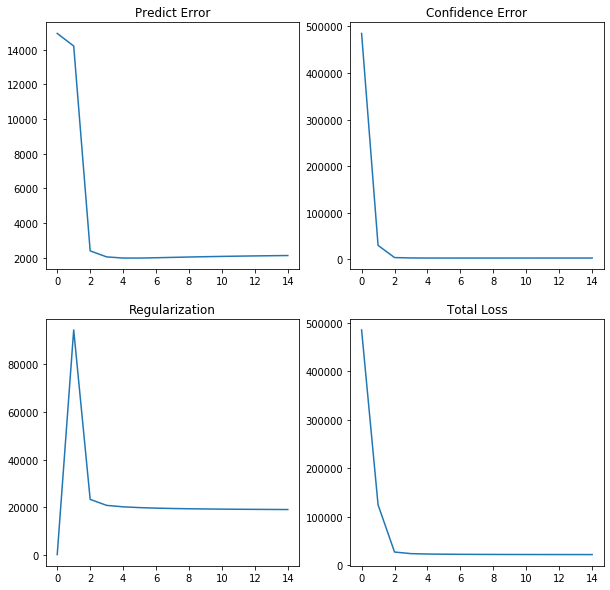

In [85]:
from matplotlib import pyplot as plt
%matplotlib inline

plt.subplots_adjust(wspace=100.0, hspace=20.0)
fig = plt.figure()
fig.set_figheight(10)
fig.set_figwidth(10)
predict_error_line = fig.add_subplot(2, 2, 1)
confidence_error_line = fig.add_subplot(2, 2, 2)
regularization_error_line = fig.add_subplot(2, 2, 3)
total_loss_line = fig.add_subplot(2, 2, 4)

predict_error_line.set_title("Predict Error") 
predict_error_line.plot(predict_errors)

confidence_error_line.set_title("Confidence Error")
confidence_error_line.plot(confidence_errors)

regularization_error_line.set_title("Regularization")
regularization_error_line.plot(regularization_list)

total_loss_line.set_title("Total Loss")
total_loss_line.plot(total_losses)
plt.show()